# Comprehensive Data Understanding and Preprocessing Strategy

---

## **1. Data Understanding**

### **Objective**  
Gain insights into the directory hierarchy (`country → bank → language → type`) and analyze checks distribution patterns to understand data and identify anomalies.

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import easyocr
from skimage.filters import threshold_local
import os
from collections import defaultdict
import squarify



### **1.1 Import Data**

In [35]:
import os
from collections import defaultdict

def parse_directory_structure(base_path):
    country_data = defaultdict(int)
    bank_data = defaultdict(int)
    language_data = defaultdict(int)
    type_data = defaultdict(int)
    
    for root, dirs, files in os.walk(base_path):
        if root == base_path:
            continue
        
        rel_path = os.path.relpath(root, base_path)
        path_parts = rel_path.split(os.sep)
        
        if len(path_parts) < 4:
            continue
        
        # Extract components
        country = path_parts[0]  # First part is always country
        bank = path_parts[1]     # Second part is bank
        language = path_parts[2] # Third part is language
        doc_type = path_parts[3] # Fourth part is type
        
        # Aggregate counts
        country_data[country] += len(files)
        bank_data[f"{country}/{bank}"] += len(files)
        language_data[f"{country}/{bank}/{language}"] += len(files)
        type_data[f"{country}/{bank}/{language}/{doc_type}"] += len(files)
    
    return country_data, bank_data, language_data, type_data
def importData(image_path):
    # Load and display the check image
    image = cv2.imread(image_path)
    original_image = image.copy()
    # Convert image to RGB for proper display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Load data
base_path = "./data"  
country_data, bank_data, language_data, type_data = parse_directory_structure(base_path)


## **1.2 Data Structure**

In [36]:
import os

def print_directory(dir_path, prefix, is_last):
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    count = len(files)
    dir_name = os.path.basename(dir_path)
    
    connector = '└── ' if is_last else '├── '
    line = f"{prefix}{connector}{dir_name}"
    if count > 0:
        line += f" ({count})"
    print(line)
    
    subdirs = sorted([d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))])
    for i, subdir in enumerate(subdirs):
        is_last_subdir = i == len(subdirs) - 1
        new_prefix = prefix + ('    ' if is_last else '│   ')
        print_directory(os.path.join(dir_path, subdir), new_prefix, is_last_subdir)

base_path = "./data"
root_dirs = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

for dir_name in root_dirs:
    dir_path = os.path.join(base_path, dir_name)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    count = len(files)
    print(f"{dir_name} ({count})")
    
    subdirs = sorted([d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))])
    for i, subdir in enumerate(subdirs):
        is_last_subdir = i == len(subdirs) - 1
        print_directory(os.path.join(dir_path, subdir), "", is_last_subdir)

india (0)
├── axis bank
│   ├── en
│   │   ├── hand_writing (30)
│   │   └── scaned
│   └── fr
│       ├── hand_writing
│       └── scaned
├── canara bank
│   ├── en
│   │   ├── hand_writing (7)
│   │   └── scaned
│   └── fr
│       ├── hand_writing
│       └── scaned
├── foeinx
│   ├── en
│   │   ├── hand_writing
│   │   └── scaned (2)
│   └── fr
│       ├── hand_writing
│       └── scaned
├── icici bank
│   ├── en
│   │   ├── hand_writing (3)
│   │   └── scaned
│   └── fr
│       ├── hand_writing
│       └── scaned
└── syndicate bank
    ├── en
    │   ├── hand_writing (3)
    │   └── scaned
    └── fr
        ├── hand_writing
        └── scaned
tunisia (0)
├── atb
│   ├── en
│   │   ├── hand_writing
│   │   └── scaned
│   ├── fr
│   │   ├── hand_writing
│   │   └── scaned
│   └── mixed
│       ├── hand_writing (4)
│       └── scaned (1)
└── tijari
    ├── en
    │   ├── hand_writing
    │   └── scaned
    ├── fr
    │   ├── hand_writing
    │   └── scaned
    └── mixed
        ├── h

### **1.3 Data Analysis**

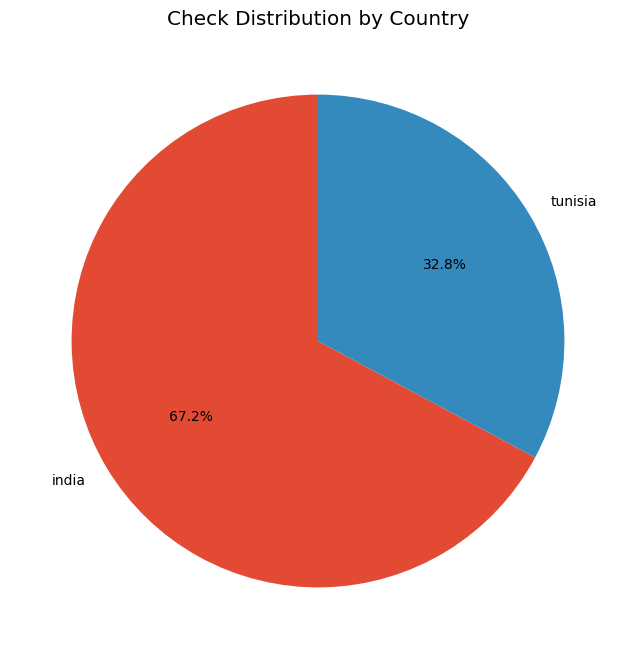

In [37]:
# ---------------------------
# Step 2: Generate Charts
# ---------------------------
plt.style.use('ggplot')

# 1. File Distribution by Country (Pie Chart)
def plot_country_distribution(country_data):
    labels = list(country_data.keys())
    sizes = list(country_data.values())
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title('Check Distribution by Country')
    plt.show()

plot_country_distribution(country_data)

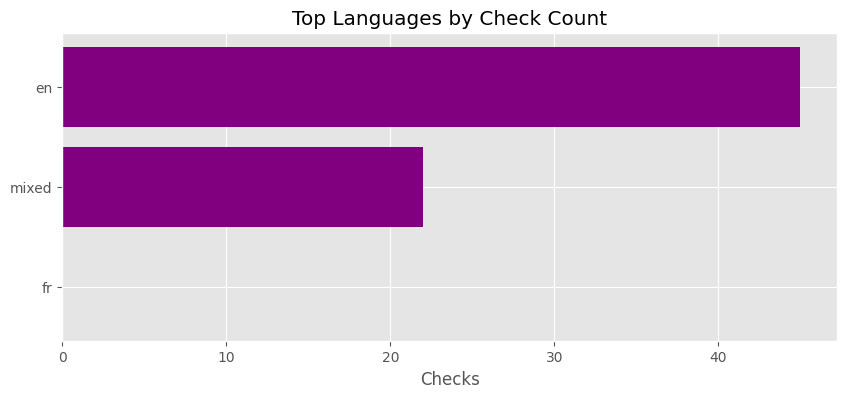

In [38]:
# 6. Top Languages (Overall)
lang_total = defaultdict(int)
for key in language_data:
    parts = key.split('/')
    if len(parts) >= 3:
        lang = parts[2]
        lang_total[lang] += language_data[key]

sorted_langs = sorted(lang_total.items(), key=lambda x: x[1], reverse=True)
langs, counts = zip(*sorted_langs)

plt.figure(figsize=(10, 4))
plt.barh(langs[::-1], counts[::-1], color='purple')
plt.title('Top Languages by Check Count')
plt.xlabel('Checks')
plt.show()

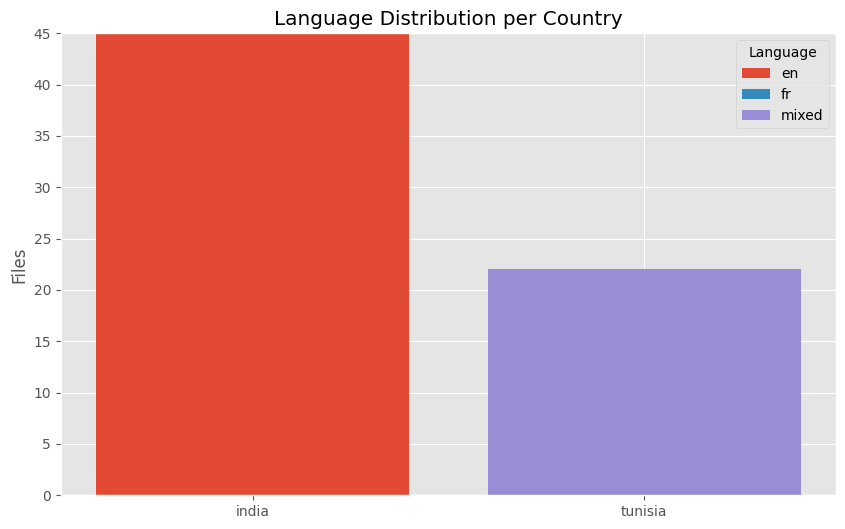

In [39]:
country_lang = defaultdict(lambda: defaultdict(int))
for key in language_data:
    parts = key.split('/')
    if len(parts) >= 3:
        country, _, lang = parts
        country_lang[country][lang] += language_data[key]

# Plot
countries = list(country_lang.keys())
languages = sorted({lang for c in countries for lang in country_lang[c].keys()})

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(countries))
for lang in languages:
    counts = [country_lang[c].get(lang, 0) for c in countries]
    ax.bar(countries, counts, label=lang, bottom=bottom)
    bottom += np.array(counts)

ax.set_title('Language Distribution per Country')
ax.set_ylabel('Files')
ax.legend(title='Language')
plt.show()

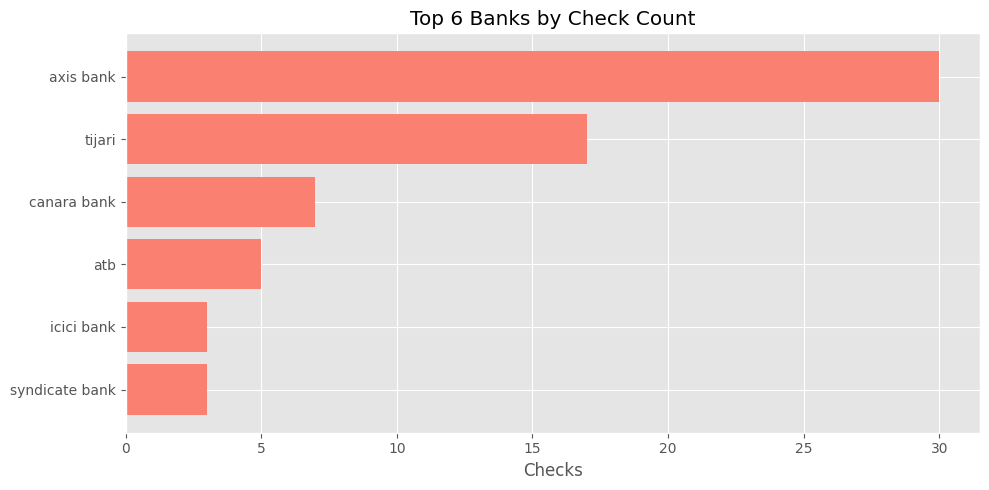

In [40]:
def plot_top_banks(bank_data, top_n=6):
    sorted_banks = sorted(bank_data.items(), key=lambda x: x[1], reverse=True)[:top_n]
    banks = [b[0].split('/')[-1] for b in sorted_banks]
    counts = [b[1] for b in sorted_banks]
    
    plt.figure(figsize=(10, 5))
    plt.barh(banks[::-1], counts[::-1], color='salmon')
    plt.title(f'Top {top_n} Banks by Check Count')
    plt.xlabel('Checks')
    plt.tight_layout()
    plt.show()

plot_top_banks(bank_data)

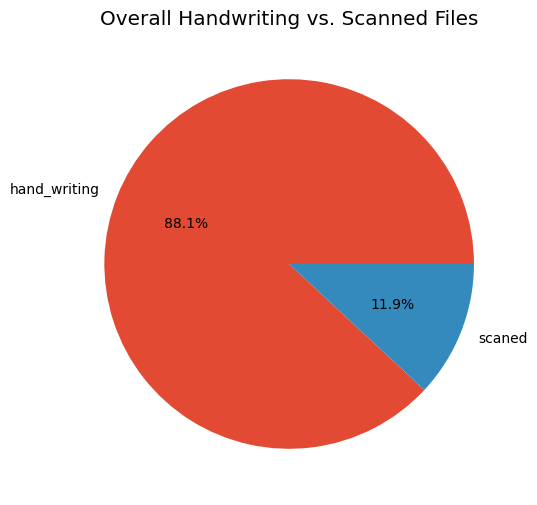

In [41]:
type_total = defaultdict(int)
for key in type_data:
    parts = key.split('/')
    if len(parts) >= 4:
        doc_type = parts[3]
        type_total[doc_type] += type_data[key]

plt.figure(figsize=(6, 6))
plt.pie(type_total.values(), labels=type_total.keys(), autopct='%1.1f%%')
plt.title('Overall Handwriting vs. Scanned Files')
plt.show()

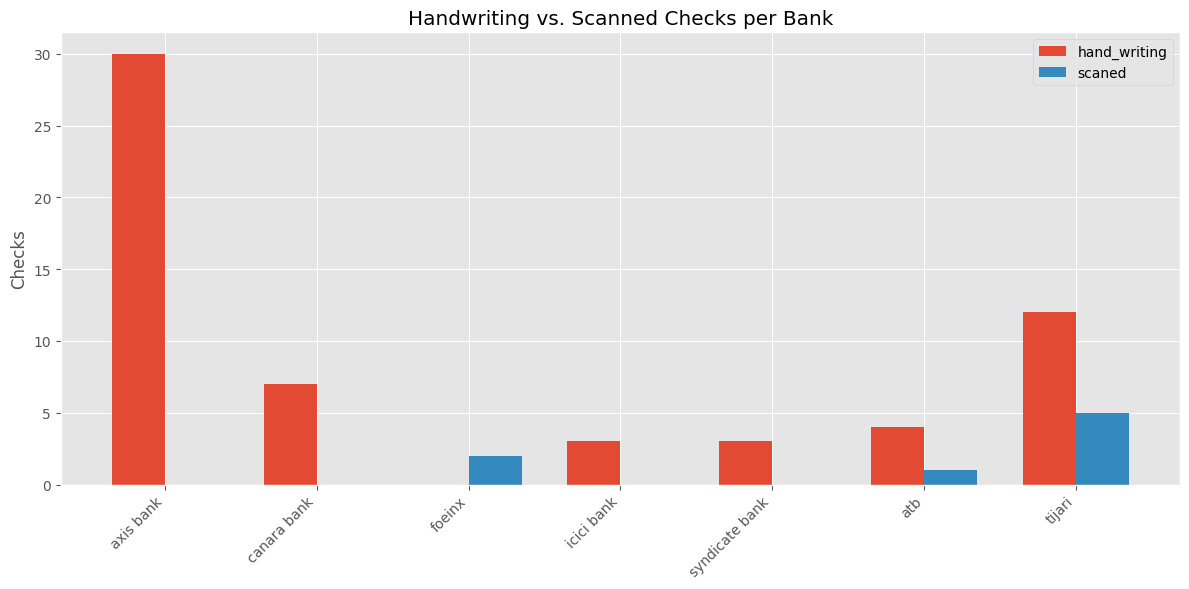

In [42]:
bank_type_counts = defaultdict(lambda: defaultdict(int))
for key in type_data:
    parts = key.split('/')
    if len(parts) >= 4:
        country, bank, _, doc_type = parts
        bank_key = f"{country}/{bank}"
        bank_type_counts[bank_key][doc_type] += type_data[key]

# Plot
banks = list(bank_type_counts.keys())
types = ['hand_writing', 'scaned']  
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(banks))
for i, doc_type in enumerate(types):
    counts = [bank_type_counts[bank].get(doc_type, 0) for bank in banks]
    ax.bar(x + i*width, counts, width, label=doc_type)

ax.set_title('Handwriting vs. Scanned Checks per Bank')
ax.set_ylabel('Checks')
ax.set_xticks(x + width/2)
ax.set_xticklabels([b.split('/')[-1] for b in banks], rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# Challenges Encountred (in Checking Image Data)
---
## **1. Structural Inconsistencies**
- **Varied Layouts**: Different check designs across banks/countries.  
- **Overlapping Text**: watermarks overlapping critical data.  

### **Example**  
`data/india/icici bank/en/hand_writing/Cheque 100830.tif` → Bank name on check background.  




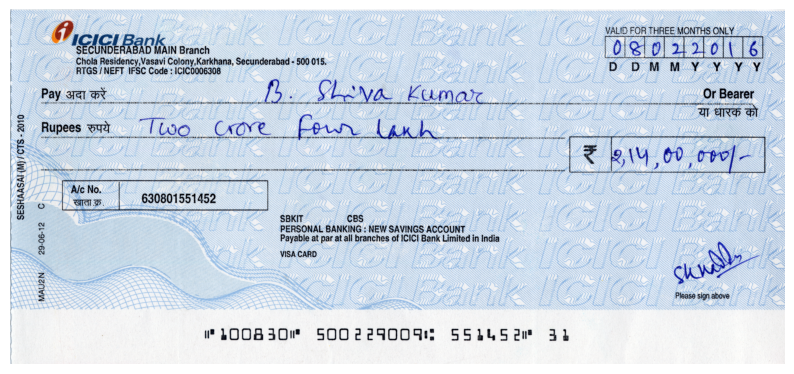

In [43]:
importData('./data/india/icici bank/en/hand_writing/Cheque 100830.tif')

---
## **3. Content-Based Challenges**
- **Multilingual Text**: Mix of languages   

### **Example**  
`india/canara_bank/en/hand_writing/check_003.jpg`




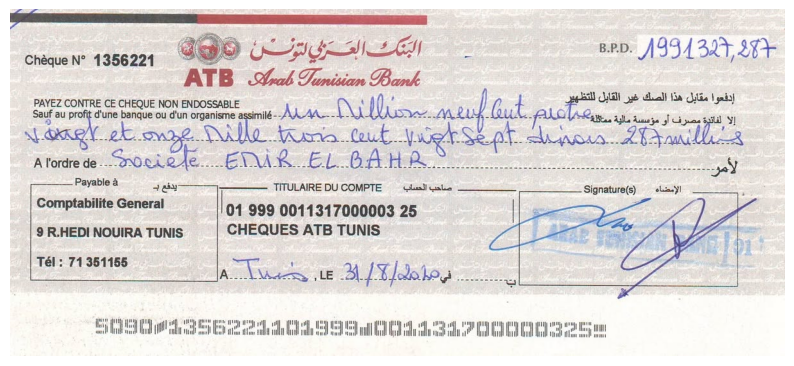

In [44]:
importData('./data/tunisia/atb/mixed/hand_writing/check1.jpg')